In [2]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations


warnings.filterwarnings('ignore')

# Load data
ust_futures = pd.read_csv('raw_futures_prices.csv', index_col=0, parse_dates=[0]).dropna(how='any', axis=0)

# Potential pairs.
pairs = list(combinations(ust_futures.columns, 2))

# Define spreads
# TODO LATER: Pull spreads from Chi-Wai's email.

from collections import defaultdict
from more_itertools import windowed

import v2.copulas.fitting as fitting
import v2.backtest.hedging as hedging
import v2.backtest.backtester as backtester
import v2.backtest.signal_ as signal_
import v2.backtest.plotting as plotting

%load_ext autoreload
%autoreload 2

In [29]:
def plot_signal(pair, signal_object, trading_price, test_start, test_end):
    sig1, sig2 = signal_object.calc_signals(single = False)
    
    trading_price = trading_price.loc[test_start:test_end]
    signals = signal_object.generate_signals(sig1 = sig1[pair], sig2 = sig2[pair])
    signals = pd.DataFrame(data=signals['Signal'].values, index=trading_price.index, columns=['Signal'])

    pair_leg_1 = pair[0]
    pair_leg_2 = pair[1]
    beta = 1

    execution_delay = 1
    prepped = pd.DataFrame(
        data={
            f'Leg 1 VWAP {execution_delay}': trading_price[pair_leg_1],
            f'Leg 2 VWAP {execution_delay}': trading_price[pair_leg_2],
            f'Volume 1': int(1e7),
            f'Volume 2': int(1e7),
            f'Leg 1 VWAP Volume {execution_delay}': int(1e7),
            f'Leg 2 VWAP Volume {execution_delay}': int(1e7),
            f'Signal {execution_delay}': signals['Signal'].shift(1).fillna(0),
            'Betas': beta,
            'FFR': 0.01
        }
    )
    backtest_res = backtester.simulate_pair(prepped, K=50_000, delay_time=execution_delay)

    plotting.plot_backtested(pair, trading_price, signals, beta, sig1, sig2, backtest_res, test_start, test_end)

In [32]:
# PnL analysis for each pair.
yearly_copulas = defaultdict(dict)

# Make a list of years.
years = ['2018', '2019', '2020', '2021', '2022']
years_windowed = list(windowed(years, 3))
result = defaultdict(dict)

for train_start, train_end, test_end in years_windowed:
    print(train_start, train_end, test_end)
    test_start = test_end
    yearly_signal_obj = signal_.SignalGeneration(ust_futures, pairs, train_start, train_end, test_start, oos_end = test_end, copula_type='gumbel')
    for pair in pairs:
        result[pair][test_end] = [yearly_signal_obj, test_start, test_end]

2018 2019 2020
2019 2020 2021
2020 2021 2022


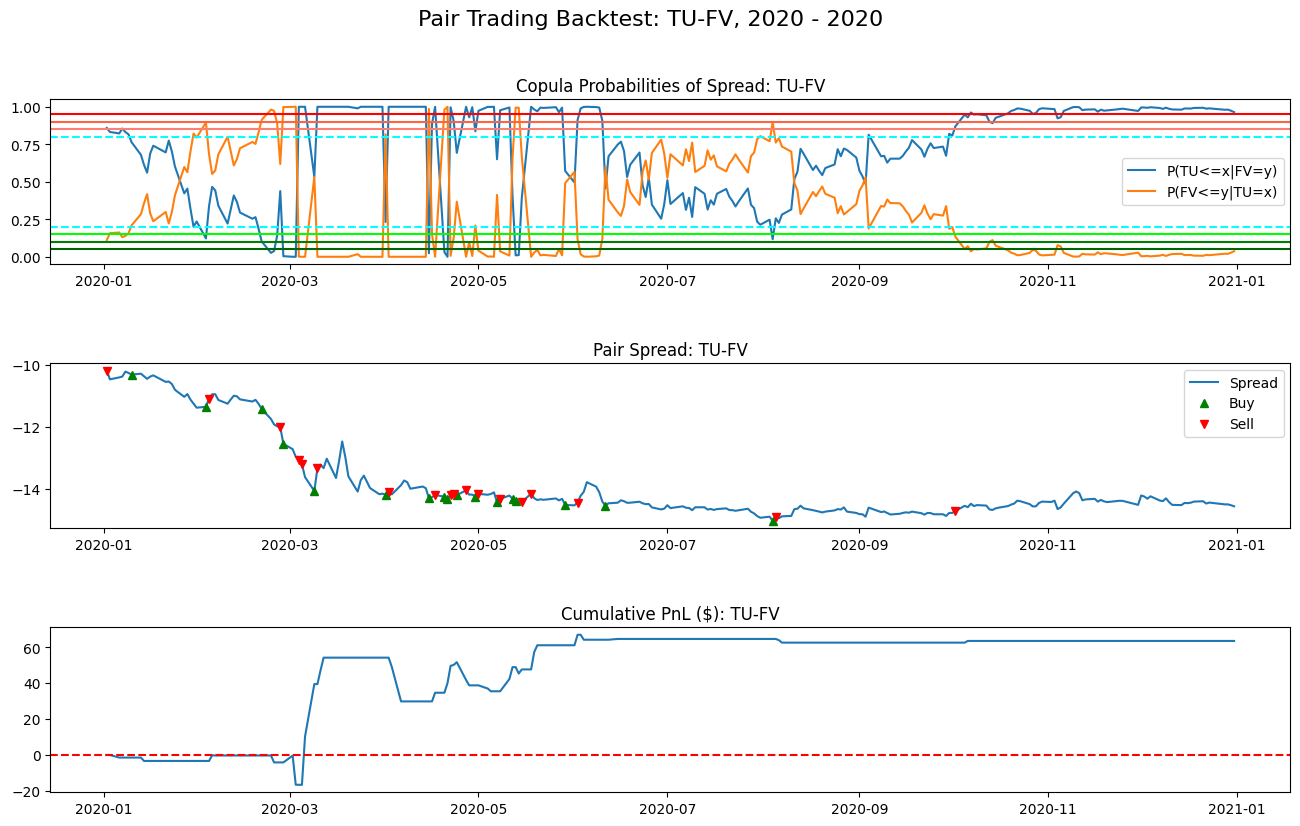

In [31]:
ind, year = 0, 0
pair = list(result.keys())[ind]
backtest_result = result[pair][year]
plot_signal(pair, backtest_result[0], ust_futures, backtest_result[1], backtest_result[2])